<a href="https://colab.research.google.com/github/hassnaakharboush/soft/blob/main/GA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost pyswarms --quiet

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import xgboost as xgb
import pyswarms as ps
import random

# --- Load and preprocess dataset ---
df = pd.read_csv('/content/data.csv')  # Change path as needed

# Drop highly correlated features (threshold 0.9)
corr_matrix = df.drop('Bankrupt?', axis=1).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
df.drop(columns=to_drop, inplace=True)
print(f"Dropped features: {to_drop}")

X = df.drop('Bankrupt?', axis=1).values
y = df['Bankrupt?'].values

# Handle missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- Evaluation function ---
def print_metrics(y_true, y_pred, title=""):
    print(f"\n--- {title} ---")
    print(classification_report(y_true, y_pred, zero_division=0))
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred, zero_division=0):.4f}")

def evaluate_model(X_tr, X_te, y_tr, y_te):
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    return y_pred

# -------------------------
# 1) Baseline XGBoost (all features)
# -------------------------
model_all = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_all.fit(X_train, y_train)
y_pred_all = model_all.predict(X_test)
print_metrics(y_test, y_pred_all, "XGBoost (All Features)")


Dropped features: [' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' Realized Sales Gross Margin', ' Pre-tax net Interest Rate', ' After-tax net Interest Rate', ' Continuous interest rate (after tax)', ' Net Value Per Share (A)', ' Net Value Per Share (C)', ' Per Share Net profit before tax (Yuan ¥)', ' Regular Net Profit Growth Rate', ' Net worth/Assets', ' Operating profit/Paid-in capital', ' Net profit before tax/Paid-in capital', ' Cash Flow to Sales', ' Current Liability to Liability', ' Current Liability to Equity', ' Net Income to Total Assets', ' Gross Profit to Sales', ' Liability to Equity']


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:51:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- XGBoost (All Features) ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1320
           1       0.59      0.30      0.39        44

    accuracy                           0.97      1364
   macro avg       0.78      0.64      0.69      1364
weighted avg       0.96      0.97      0.97      1364

Accuracy:  0.9707
Precision: 0.5909
Recall:    0.2955
F1 Score:  0.3939


In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from deap import base, creator, tools, algorithms
import random

# --- 1. Define your evaluation function for GA ---
def evaluate_features(selected_features):
    if np.count_nonzero(selected_features) == 0:
        return 0.0,
    cols = [i for i, bit in enumerate(selected_features) if bit == 1]
    X_train_sel = X_train[:, cols]
    X_test_sel = X_test[:, cols]

    model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)

    acc = accuracy_score(y_test, y_pred)
    return acc,  # tuple for DEAP

# --- 2. Setup DEAP GA framework ---
num_features = X_train.shape[1]

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate_features)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# --- 3. Run the GA ---
population = toolbox.population(n=30)
NGEN = 100
CXPB, MUTPB = 0.5, 0.2

for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = list(map(toolbox.evaluate, offspring))
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))
    top_ind = tools.selBest(population, k=1)[0]
    print(f"Gen {gen} Best Accuracy: {top_ind.fitness.values[0]:.4f}")

# --- 4. Best feature subset and final evaluation ---
best_individual = tools.selBest(population, k=1)[0]
selected_features = [i for i, bit in enumerate(best_individual) if bit == 1]

print(f"Selected Features: {selected_features}")

model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
model.fit(X_train[:, selected_features], y_train)
y_pred = model.predict(X_test[:, selected_features])

print("Final Model Evaluation with GA-selected features:")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))


/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Gen 0 Best Accuracy: 0.9773
Gen 1 Best Accuracy: 0.9773
Gen 2 Best Accuracy: 0.9773
Gen 3 Best Accuracy: 0.9773
Gen 4 Best Accuracy: 0.9773
Gen 5 Best Accuracy: 0.9773
Gen 6 Best Accuracy: 0.9773
Gen 7 Best Accuracy: 0.9773
Gen 8 Best Accuracy: 0.9773
Gen 9 Best Accuracy: 0.9773
Gen 10 Best Accuracy: 0.9773
Gen 11 Best Accuracy: 0.9773
Gen 12 Best Accuracy: 0.9773
Gen 13 Best Accuracy: 0.9773
Gen 14 Best Accuracy: 0.9773
Gen 15 Best Accuracy: 0.9773
Gen 16 Best Accuracy: 0.9773
Gen 17 Best Accuracy: 0.9773
Gen 18 Best Accuracy: 0.9773
Gen 19 Best Accuracy: 0.9773
Gen 20 Best Accuracy: 0.9773
Gen 21 Best Accuracy: 0.9773
Gen 22 Best Accuracy: 0.9773
Gen 23 Best Accuracy: 0.9773
Gen 24 Best Accuracy: 0.9773
Gen 25 Best Accuracy: 0.9773
Gen 26 Best Accuracy: 0.9773
Gen 27 Best Accuracy: 0.9773
Gen 28 Best Accuracy: 0.9773
Gen 29 Best Accuracy: 0.9773
Gen 30 Best Accuracy: 0.9773
Gen 31 Best Accuracy: 0.9773
Gen 32 Best Accuracy: 0.9773
Gen 33 Best Accuracy: 0.9773
Gen 34 Best Accuracy: 0.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import xgboost as xgb
import pyswarms as ps

# Assume X, y are your dataset features and labels
# X, y = ...

# 1. Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Define PSO fitness function with 3-fold CV and faster XGBoost model
def pso_fitness(x):
    scores = []
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    for particle in x:
        mask = particle > 0.5
        if np.sum(mask) == 0:
            scores.append(0.0)
            continue
        cols = np.where(mask)[0]
        fold_acc = []
        for train_idx, val_idx in skf.split(X_train, y_train):
            X_tr, X_val = X_train[train_idx][:, cols], X_train[val_idx][:, cols]
            y_tr, y_val = y_train[train_idx], y_train[val_idx]

            model = xgb.XGBClassifier(
                learning_rate=0.1,
                max_depth=3,
                n_estimators=100,
                subsample=0.8,
                colsample_bytree=0.8,
                gamma=0.1,
                reg_alpha=0.1,
                reg_lambda=1.0,
                eval_metric='logloss',
                use_label_encoder=False,
                random_state=42,
                verbosity=0
            )
            model.fit(X_tr, y_tr, verbose=False)
            y_pred = model.predict(X_val)
            fold_acc.append(accuracy_score(y_val, y_pred))
        scores.append(np.mean(fold_acc))
    return -np.array(scores)  # PSO minimizes cost

# 4. Set PSO parameters — fewer particles and iterations for speed
options = {'c1': 2.0, 'c2': 2.0, 'w': 0.7}
optimizer = ps.single.GlobalBestPSO(
    n_particles=10,              # fewer particles = faster but less exploration
    dimensions=X_train.shape[1],
    options=options
)

# 5. Run the optimization
cost, pos = optimizer.optimize(pso_fitness, iters=50)

# 6. Selected features mask from PSO position
selected_features_pso = pos > 0.5
print(f"PSO selected {np.sum(selected_features_pso)} features.")

# 7. Train final model on selected features with original data split and parameters
final_model = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    verbosity=0
)

final_model.fit(X_train[:, selected_features_pso], y_train)
y_pred = final_model.predict(X_test[:, selected_features_pso])

# 8. Print evaluation metrics
print("PSO + XGBoost Results:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")


2025-05-17 19:21:32,370 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2.0, 'c2': 2.0, 'w': 0.7}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-0.971
2025-05-17 19:27:24,349 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9710357786740742, best pos: [ 0.39022761  0.78198232  0.60014116  0.58203773  0.25752995 -1.69620362
  0.89618858 -2.20675027  2.2137895   0.20656056  0.64493225  1.70714694
  0.20488422 -0.91151985  0.37027943  0.92175284  0.62282197  0.01865331
 -1.2532904   0.83189477 -0.17115541  0.73718218  0.02623513  0.29144141
  1.00785582  0.27663401  1.57677823  0.0723026   0.45168068  0.3562955
  0.88221012  0.74209558  2.50820823  0.56699357  0.87315681  0.14917497
  0.24428744  0.48726408  0.64761423  0.52213194  0.36933729  0.84316211
  0.77876703  0.6710913   0.13449324  0.17121001  1.09488393  0.89868525
  1.16466289  0.41456938  0.56017449  0.7653165  -0.48155141  0.71181226
  0.06648538  0.4883750

PSO selected 38 features.
PSO + XGBoost Results:
Accuracy:  0.9648
Precision: 0.4091
Recall:    0.2045
F1 Score:  0.2727


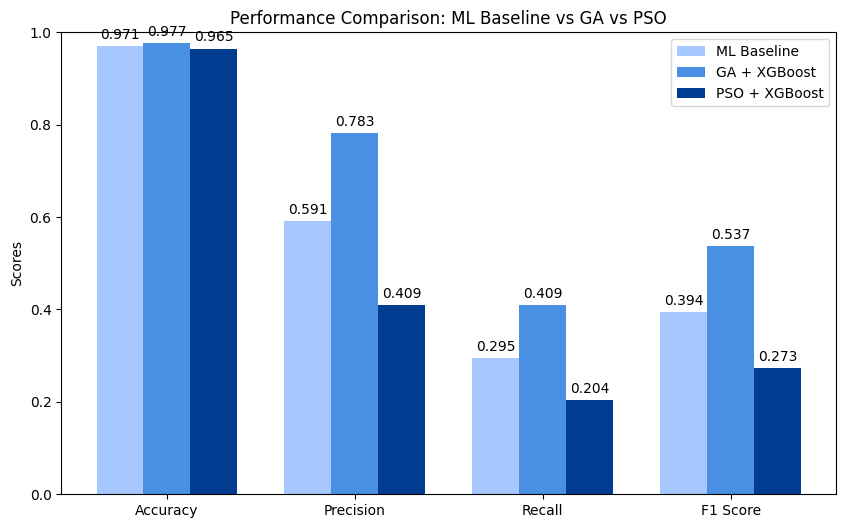

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics and actual results you provided
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

ml_scores = [0.9707, 0.5909, 0.2955, 0.3939]       # Baseline ML
ga_scores = [0.9773, 0.7826, 0.4091, 0.5373]       # GA + XGBoost
pso_scores = [0.9648, 0.4091, 0.2045, 0.2727]      # PSO + XGBoost

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(10,6))

# Blue shades from light to dark
colors = ['#a6c8ff', '#4a90e2', '#003c8f']

rects1 = ax.bar(x - width, ml_scores, width, label='ML Baseline', color=colors[0])
rects2 = ax.bar(x, ga_scores, width, label='GA + XGBoost', color=colors[1])
rects3 = ax.bar(x + width, pso_scores, width, label='PSO + XGBoost', color=colors[2])

ax.set_ylabel('Scores')
ax.set_title('Performance Comparison: ML Baseline vs GA vs PSO')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim([0, 1])
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.show()
